In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torch import Tensor

import torchvision
import torchvision.datasets as datasets

import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm

from IPython import display

%load_ext autoreload
%autoreload 2

In [2]:
class MasksDataset(data.Dataset):
    def __init__(self, file):
        data = np.load(file)
        
        self.images = self.torch_image(data["images"]) if "images" in data else None
        self.masks  = self.torch_image(data["masks"]) if "masks" in data else None
        self.labels = torch.from_numpy(data["labels"]).cuda() if "labels" in data else None

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        return {
            "images": self.images[idx],
            "masks": self.masks[idx] if self.masks is not None else self.images[idx],
            "labels": self.labels[idx] if self.labels is not None else self.images[idx]
        }
        
    def torch_image(self, img):
        return torch.from_numpy(img.astype(np.float32)).permute(0,3,1,2).cuda()

In [3]:
dir = "data/fashion-masks"

train = MasksDataset(f"{dir}/fashion-masks-train.npz")
dev = MasksDataset(f"{dir}/fashion-masks-dev.npz")
test = MasksDataset(f"{dir}/fashion-masks-test.npz")

In [4]:
def imshow(images, cols=10, figsize=(15,6)):
    n = len(images)
    
    images = images.permute(0,2,3,1).cpu().numpy()
        
    im = images[:,:,:,0]
    
    plt.figure(figsize=figsize)
    
    for i in range(n):
        plt.subplot(n // cols + 1, cols, i + 1)
        plt.axis("off")
        plt.imshow(im[i], cmap="gray")
        
    plt.tight_layout()
    plt.show()

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size()[0], -1)

class ConvBlock(nn.Module):
    def __init__(self, inputs=32, outputs=32):
        super(ConvBlock, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(inputs, outputs, 3, padding=1),
            nn.BatchNorm2d(outputs),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
    def forward(self, x):
        return self.model(x)

class DeconvBlock(nn.Module):
    def __init__(self, inputs=32, outputs=32):
        super(DeconvBlock, self).__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(inputs, outputs, 3, padding=1),
            nn.BatchNorm2d(outputs),
            nn.ReLU(),
            nn.Upsample(scale_factor=2),
        )
        
    def forward(self, x):
        return self.model(x)
    
class Trainer:
    def __init__(self, model, lr, criterion, gamma=0.95, step_size=100):
        self.model = model
        self.optimizer = optim.Adam(model.parameters(), lr=lr)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=step_size, gamma=gamma)
        self.criterion = criterion
        self.losses = []
        
    def fit(self, loader, label_fn, epochs=5, print_each=100):
        self.losses = []
        
        self.model.train()
        
        for epoch in range(epochs):
            for i, batch in enumerate(loader):
                self.scheduler.step()

                images = Variable(batch["images"])
                masks = Variable(batch["masks"])

                y_pred = self.model(images)
                loss = self.criterion(y_pred, label_fn(batch))

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()

                self.losses.append(np.log(loss.data[0]))
                
                if i % 100 == 0 and i > 0:
                    plt.plot(self.losses)
                    display.clear_output(wait=True)
                    display.display(plt.show())

                    print("epoch: {}".format(epoch))
                    print("label_loss: {:0.4f} label_LR: {:0.4f}".format(loss.data[0], self.scheduler.get_lr()[0]))

        self.model.eval()

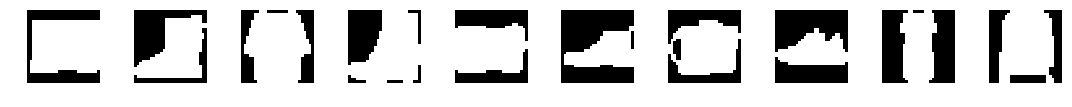

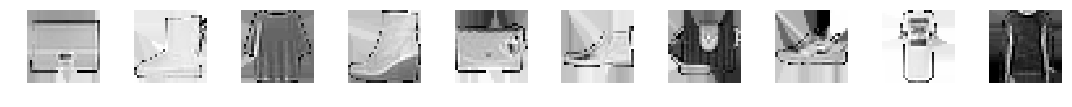

In [5]:
imshow(train.masks[:10])
imshow(train.images[:10])

In [6]:
BATCH_SIZE = 256
train_loader = data.DataLoader(train, batch_size=BATCH_SIZE)
dev_loader = data.DataLoader(dev, batch_size=BATCH_SIZE)
test_loader = data.DataLoader(test, batch_size=BATCH_SIZE)

# Model definition

In [58]:
mask_model = nn.Sequential(
    ConvBlock(1, 128),
    ConvBlock(128, 256),
    DeconvBlock(256, 128),
    DeconvBlock(128, 128),
    
    nn.Conv2d(128, 1, 3, padding=1),
    nn.Sigmoid()
).cuda()

In [32]:
label_model = nn.Sequential(
    ConvBlock(1, 64),
    ConvBlock(64, 64),
    ConvBlock(64, 128),
    ConvBlock(128, 128),
    
    Flatten(),
    nn.Linear(128, 1024),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(1024, 1024),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(1024, 10),
    nn.Softmax(1)
).cuda()

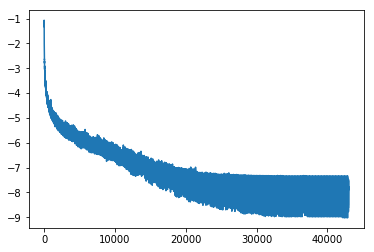

None

epoch: 199
label_loss: 0.0004 label_LR: 0.0001


In [59]:
mask_trainer = Trainer(mask_model, 0.01, nn.MSELoss(), step_size=500)
mask_trainer.fit(train_loader, lambda batch: Variable(batch["masks"]).cuda(), epochs=200)

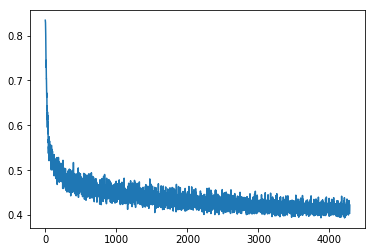

None

epoch: 19
label_loss: 1.4981 label_LR: 0.0002


In [33]:
label_trainer = Trainer(label_model, 0.0005, nn.CrossEntropyLoss(), step_size=200)
label_trainer.fit(train_loader, lambda batch: Variable(batch["labels"]).cuda(), epochs=20)

# Save and load model

In [60]:
torch.save(mask_model, "mask_model.pkl")
torch.save(label_model, "label_model.pkl")

C:\dev\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type ConvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\dev\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type DeconvBlock. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\dev\Anaconda3\lib\site-packages\torch\serialization.py:159: UserWarning: Couldn't retrieve source code for container of type Flatten. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
mask_model = torch.load("mask_model.pkl").eval()
label_model = torch.load("label_model.pkl").eval()

# Generate output data for eval

In [66]:
y_masks = []
y_labels = []

for batch in test_loader:
    y_labels.append(label_model(Variable(batch["images"]).cuda()).cpu().data.numpy())
    y_masks.append(mask_model(Variable(batch["images"]).cuda()).cpu().data.permute(0, 2, 3, 1).numpy())
    
y_labels = np.argmax(np.vstack(y_labels), axis=1)
y_masks = np.vstack(y_masks)

In [62]:
true_labels = dev[:]["labels"].cpu().numpy()

In [63]:
np.mean(true_labels == y_labels)

0.90700000000000003

In [64]:
a = torch.from_numpy(y_masks).round().byte().cpu()
b = dev[:]["masks"].round().byte().cpu().permute(0,2,3,1)

(a & b).float().sum() / (a | b).float().sum()

0.987692196290195

In [67]:
with open("fashion_masks_test.txt", "w") as test_file:
    for i in range(len(y_labels)):
        print(y_labels[i], *y_masks[i].astype(np.uint8).flatten(), file=test_file)

# Mask previews

In [ ]:
NUM_TO_COMPARE=2000

dev_compare = dev[:NUM_TO_COMPARE]["masks"]
gen_compare = mask_model(Variable(dev[:NUM_TO_COMPARE]["images"])).data

a = dev_compare.round().byte()
b = gen_compare.round().byte()

(a & b).float().sum() / (a | b).float().sum()

In [ ]:
imshow(gen_compare[:20].round(), figsize=(15, 5))

In [ ]:
imshow(dev_compare[:20], figsize=(15, 5))